# Linear vs Nonlinear Regression for Predicting Seoul Bike Rental Demand

In [1]:
import pandas as pd
file_path = "SeoulBikeData.csv"
df = pd.read_csv(file_path, encoding="latin1")
# Quick peek
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [2]:
# Structure: column names, types, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [3]:
# Check missing values
df.isna().sum()


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [4]:
# Basic stats for numeric columns
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


In [5]:
df.columns = (
    df.columns
      .str.strip()
      .str.replace(' ', '_')
      .str.replace(r'[()/]', '', regex=True)
      .str.replace('°C', 'C')
)

df.columns

Index(['Date', 'Rented_Bike_Count', 'Hour', 'TemperatureC', 'Humidity%',
       'Wind_speed_ms', 'Visibility_10m', 'Dew_point_temperatureC',
       'Solar_Radiation_MJm2', 'Rainfallmm', 'Snowfall_cm', 'Seasons',
       'Holiday', 'Functioning_Day'],
      dtype='object')

In [6]:
# Parse date (dataset uses day/month/year)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Time-based features
df['year']       = df['Date'].dt.year
df['month']      = df['Date'].dt.month
df['dayofweek']  = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

df[['Date', 'year', 'month', 'dayofweek', 'is_weekend']].head()

,Date,year,month,dayofweek,is_weekend
0,2017-12-01,2017,12,4,0
1,2017-12-01,2017,12,4,0
2,2017-12-01,2017,12,4,0
3,2017-12-01,2017,12,4,0
4,2017-12-01,2017,12,4,0


In [7]:
df[['Seasons', 'Holiday', 'Functioning_Day']].nunique(), \
df['Seasons'].value_counts(), \
df['Holiday'].value_counts(), \
df['Functioning_Day'].value_counts()


(Seasons            4
 Holiday            2
 Functioning_Day    2
 dtype: int64,
 Seasons
 Spring    2208
 Summer    2208
 Autumn    2184
 Winter    2160
 Name: count, dtype: int64,
 Holiday
 No Holiday    8328
 Holiday        432
 Name: count, dtype: int64,
 Functioning_Day
 Yes    8465
 No      295
 Name: count, dtype: int64)

## Correlation with the target (first “feature selection” hint)

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols


Index(['Rented_Bike_Count', 'Hour', 'TemperatureC', 'Humidity%',
       'Wind_speed_ms', 'Visibility_10m', 'Dew_point_temperatureC',
       'Solar_Radiation_MJm2', 'Rainfallmm', 'Snowfall_cm', 'is_weekend'],
      dtype='object')

In [9]:
corr = df[numeric_cols].corr()

# Correlation of all numeric features with the target
corr['Rented_Bike_Count'].sort_values(ascending=False)


Rented_Bike_Count         1.000000
TemperatureC              0.538558
Hour                      0.410257
Dew_point_temperatureC    0.379788
Solar_Radiation_MJm2      0.261837
Visibility_10m            0.199280
Wind_speed_ms             0.121108
is_weekend               -0.036467
Rainfallmm               -0.123074
Snowfall_cm              -0.141804
Humidity%                -0.199780
Name: Rented_Bike_Count, dtype: float64

#### TemperatureC has the strongest positive correlation with rentals (~0.54)

Hour also matters a lot (~0.41)

Humidity% and Snowfall_cm are negatively correlated (more humidity/snow → fewer rentals)

is_weekend is slightly negative (fewer rides on weekends)

## Prepare data + baseline linear regression
Encode categorical variables (Seasons, Holiday, Functioning_Day)

In [10]:
import pandas as pd

# Make a copy so we don't mess original df
df_model = df.copy()

# One-hot encode categorical columns
df_model = pd.get_dummies(
    df_model,
    columns=['Seasons', 'Holiday', 'Functioning_Day'],
    drop_first=True   # avoids dummy trap
)

df_model.columns


Index(['Date', 'Rented_Bike_Count', 'Hour', 'TemperatureC', 'Humidity%',
       'Wind_speed_ms', 'Visibility_10m', 'Dew_point_temperatureC',
       'Solar_Radiation_MJm2', 'Rainfallmm', 'Snowfall_cm', 'year', 'month',
       'dayofweek', 'is_weekend', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_No Holiday', 'Functioning_Day_Yes'],
      dtype='object')

In [11]:
target = 'Rented_Bike_Count'

# Columns we definitely don't want as predictors
drop_cols = ['Date', target]

X = df_model.drop(columns=drop_cols)
y = df_model[target]

X.shape, y.shape


((8760, 18), (8760,))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((7008, 18), (1752, 18))

In [13]:
from sklearn.linear_model import LinearRegression

#Fit a multiple linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


LinearRegression()

In [14]:
#Evaluate performance (this will be our linear baseline)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_lin = lin_reg.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin  = mean_absolute_error(y_test, y_pred_lin)
r2_lin   = r2_score(y_test, y_pred_lin)

rmse_lin, mae_lin, r2_lin


(np.float64(438.5892317362042), 330.3303345265327, 0.5383121296067849)

In [15]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': lin_reg.coef_
}).sort_values(by='coef', key=lambda s: s.abs(), ascending=False)

coef_df.head(15)


,feature,coef
17,Functioning_Day_Yes,956.972631
15,Seasons_Winter,-816.143291
9,year,-621.885490
13,Seasons_Spring,-447.008348
14,Seasons_Summer,-323.997798
16,Holiday_No Holiday,139.959091
12,is_weekend,-99.961017
6,Solar_Radiation_MJm2,-82.235275
7,Rainfallmm,-60.514968
10,month,-50.211546


### Our metrics:

RMSE ≈ 438.6

MAE ≈ 330.3

R² ≈ 0.54

### And top coefficients:

Functioning_Day_Yes +957 → on functioning days, rentals are much higher

Seasons_Winter –816 → winter strongly lowers rentals vs (baseline) Autumn

year –622 → 2018 seems to have fewer rentals than 2017

Seasons_Spring (–447), Seasons_Summer (–324), etc.

So our simple linear regression already explains ~54% of the variation, but errors are still large compared to mean rentals (705).

## Use regression/EDA to spot redundant attributes

In [16]:
# Check correlations between predictors

corr_X = X.corr()

# Show the most highly correlated predictor pairs (absolute correlation)
high_corr_pairs = (
    corr_X
    .where(np.triu(np.ones(corr_X.shape), k=1).astype(bool))  # keep upper triangle
    .stack()
    .sort_values(ascending=False)
)

high_corr_pairs.head(10)


TemperatureC            Dew_point_temperatureC    0.912798
dayofweek               is_weekend                0.789001
TemperatureC            Seasons_Summer            0.665846
Dew_point_temperatureC  Seasons_Summer            0.652378
Humidity%               Dew_point_temperatureC    0.536894
TemperatureC            year                      0.377796
                        Solar_Radiation_MJm2      0.353505
Dew_point_temperatureC  year                      0.336350
Wind_speed_ms           Solar_Radiation_MJm2      0.332274
Hour                    Wind_speed_ms             0.285197
dtype: float64

##### Drop one redundant attribute and refit linear regression

In [18]:
cols_to_drop = ['Dew_point_temperatureC']

X_train_red = X_train.drop(columns=cols_to_drop)
X_test_red  = X_test.drop(columns=cols_to_drop)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lin_reg_red = LinearRegression()
lin_reg_red.fit(X_train_red, y_train)

y_pred_lin_red = lin_reg_red.predict(X_test_red)

rmse_lin_red = np.sqrt(mean_squared_error(y_test, y_pred_lin_red))
mae_lin_red  = mean_absolute_error(y_test, y_pred_lin_red)
r2_lin_red   = r2_score(y_test, y_pred_lin_red)

rmse_lin_red, mae_lin_red, r2_lin_red


(np.float64(438.85664857761617), 330.86696184137486, 0.5377489568607308)

### Removing dew point temperature did not materially change model performance, so we consider it a redundant attribute and exclude it from further analysis.

coef_red_df = pd.DataFrame({
    'feature': X_train_red.columns,
    'coef': lin_reg_red.coef_
}).sort_values(by='coef', key=lambda s: s.abs(), ascending=False)

coef_red_df.head(15)


# Nonlinear regression models

### Polynomial regression (Temp & Hour nonlinearity)

This still uses LinearRegression, but on nonlinear features (squares + interaction), so conceptually it’s nonlinear regression.

In [21]:
# Start from reduced features
X_train_poly = X_train_red.copy()
X_test_poly  = X_test_red.copy()

# Add nonlinear terms
X_train_poly['TemperatureC_sq'] = X_train_red['TemperatureC'] ** 2
X_test_poly['TemperatureC_sq']  = X_test_red['TemperatureC'] ** 2

X_train_poly['Hour_sq'] = X_train_red['Hour'] ** 2
X_test_poly['Hour_sq']  = X_test_red['Hour'] ** 2

X_train_poly['Temp_x_Hour'] = X_train_red['TemperatureC'] * X_train_red['Hour']
X_test_poly['Temp_x_Hour']  = X_test_red['TemperatureC'] * X_test_red['Hour']

X_train_poly.shape, X_test_poly.shape


((7008, 20), (1752, 20))

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred_poly = poly_reg.predict(X_test_poly)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae_poly  = mean_absolute_error(y_test, y_pred_poly)
r2_poly   = r2_score(y_test, y_pred_poly)

rmse_poly, mae_poly, r2_poly


(np.float64(414.6695479026305), 300.8753829341949, 0.5872977639171666)

## Random Forest regression (fully nonlinear ML model)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train_red, y_train)

y_pred_rf = rf_reg.predict(X_test_red)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

rmse_rf, mae_rf, r2_rf


(np.float64(171.86480220871871), 98.64668949771689, 0.9291064995553568)

## Summary table

In [29]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Linear regression (reduced)",
        "Polynomial regression (degree 2)",
        "Random forest regression"
    ],
    "RMSE": [rmse_lin_red, rmse_poly, rmse_rf],
    "MAE":  [mae_lin_red,  mae_poly,  mae_rf],
    "R²":   [r2_lin_red,   r2_poly,   r2_rf]
})

# Round for presentation
results_rounded = results.copy()
results_rounded["RMSE"] = results_rounded["RMSE"].round(1)
results_rounded["MAE"]  = results_rounded["MAE"].round(1)
results_rounded["R²"]   = results_rounded["R²"].round(3)

results_rounded


,Model,RMSE,MAE,R²
0,Linear regression (reduced),438.9,330.9,0.538
1,Polynomial regression (degree 2),414.7,300.9,0.587
2,Random forest regression,171.9,98.6,0.929


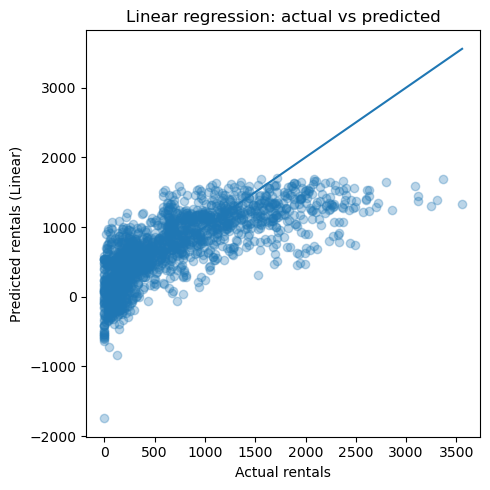

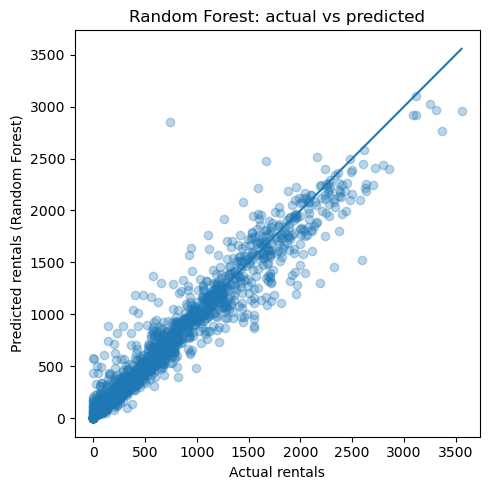

In [25]:
import matplotlib.pyplot as plt

# Linear
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_lin_red, alpha=0.3)
plt.xlabel("Actual rentals")
plt.ylabel("Predicted rentals (Linear)")
plt.title("Linear regression: actual vs predicted")
plt.plot([0, y_test.max()], [0, y_test.max()])
plt.tight_layout()
plt.show()

# Random Forest
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Actual rentals")
plt.ylabel("Predicted rentals (Random Forest)")
plt.title("Random Forest: actual vs predicted")
plt.plot([0, y_test.max()], [0, y_test.max()])
plt.tight_layout()
plt.show()


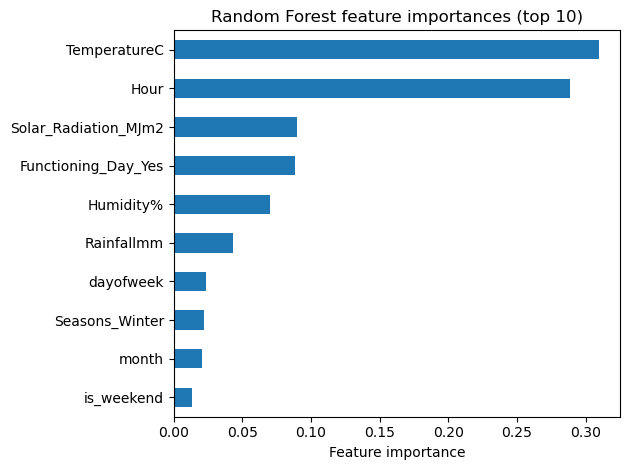

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf_reg.feature_importances_, index=X_train_red.columns)
importances.sort_values(ascending=True).tail(10).plot(kind='barh')
plt.xlabel("Feature importance")
plt.title("Random Forest feature importances (top 10)")
plt.tight_layout()
plt.show()


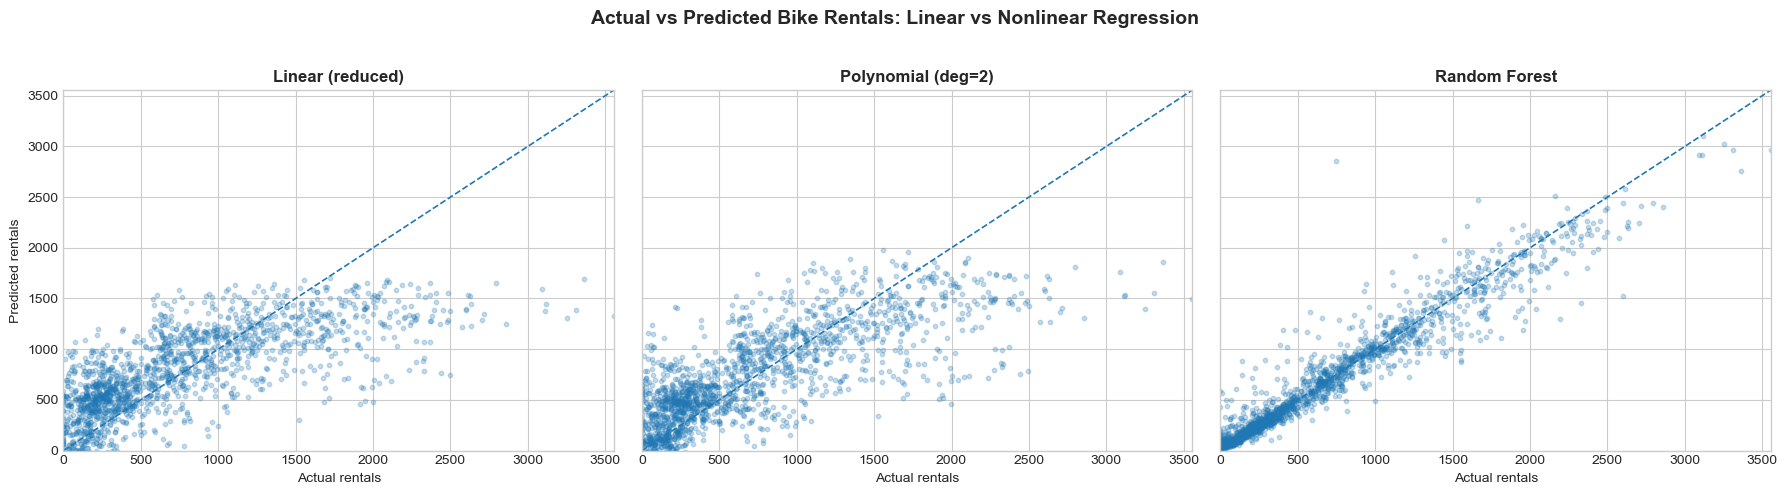

In [27]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid") 

# Put all three models into a list for easy looping
models = [
    ("Linear (reduced)", y_pred_lin_red),
    ("Polynomial (deg=2)", y_pred_poly),
    ("Random Forest", y_pred_rf)
]

# Create a single figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Global max for nice equal axes
global_max = max(y_test.max(),
                 y_pred_lin_red.max(),
                 y_pred_poly.max(),
                 y_pred_rf.max())

for ax, (title, y_pred) in zip(axes, models):
    # Scatter: actual vs predicted
    ax.scatter(
        y_test,
        y_pred,
        alpha=0.25,
        s=10
    )

    # 45° reference line (perfect predictions)
    ax.plot(
        [0, global_max],
        [0, global_max],
        linestyle="--",
        linewidth=1.2
    )

    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Actual rentals", fontsize=10)
    if ax is axes[0]:
        ax.set_ylabel("Predicted rentals", fontsize=10)

    ax.set_xlim(0, global_max)
    ax.set_ylim(0, global_max)

# Main title
fig.suptitle(
    "Actual vs Predicted Bike Rentals: Linear vs Nonlinear Regression",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.subplots_adjust(top=0.82)  # leave space for the main title

# 🔹 Save as one high-dpi image
plt.savefig("bike_rentals_model_comparison.png",
            dpi=400,
            bbox_inches="tight")

plt.show()


#### Overall, the results highlight a clear trade-off between model simplicity and predictive power. The multiple linear regression model is easy to interpret and already explains about half of the variance in bike rentals, but it cannot fully capture nonlinear effects such as the curved relationship between temperature and demand or the complex interaction between hour of day, season, and weather conditions. Adding quadratic and interaction terms in the polynomial regression improves performance modestly, showing that some nonlinearities can be handled within the regression framework. In contrast, the Random Forest, a nonlinear tree-based ensemble method, captures a much richer set of interactions and nonlinear patterns, achieving an R² of 0.93 and drastically lower prediction errors. However, this gain in accuracy comes at the cost of interpretability, as individual feature effects are no longer summarized by simple coefficients. This experiment illustrates how regression can be used both as a first step for feature selection and as a last step predictive model, and how nonlinear methods can substantially improve predictive performance when the underlying relationships are complex.

**Table 1. Correlation of key predictors with hourly bike rentals and model performance.**

| Section       | Feature / Model                  | Corr. with rentals | RMSE  | MAE   | R²    |
|--------------|-----------------------------------|--------------------|-------|-------|-------|
| Correlation  | Temperature (°C)                  | 0.539              |       |       |       |
|              | Hour of day                       | 0.410              |       |       |       |
|              | Solar radiation (MJ/m²)           | 0.262              |       |       |       |
|              | Visibility (10 m)                 | 0.199              |       |       |       |
|              | Wind speed (m/s)                  | 0.121              |       |       |       |
|              | Humidity (%)                      | –0.200             |       |       |       |
|              | Rainfall (mm)                     | –0.123             |       |       |       |
|              | Snowfall (cm)                     | –0.142             |       |       |       |
| Performance  | Linear regression (reduced)       |                    | 438.9 | 330.9 | 0.538 |
|              | Polynomial regression (degree 2)  |                    | 414.7 | 300.9 | 0.587 |
|              | Random forest regression          |                    | 171.9 |  98.6 | 0.929 |
